In [1]:
import cobra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from mmon_gcm.analysing import get_phase_lengths
from mmon_gcm.supermodel import SuperModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_theme()
sns.set_style("ticks")
palettes = {
    "tol_bright": sns.color_palette(
        ["#4477AA", "#66CCEE", "#228833", "#CCBB44", "#EE6677", "#AA3377", "#BBBBBB"]
    ),
    "tol_muted": sns.color_palette(
        [
            "#332288",
            "#88CCEE",
            "#44AA99",
            "#117733",
            "#999933",
            "#DDCC77",
            "#CC6677",
            "#882255",
            "#AA4499",
        ]
    ),
}
sns.set_palette(palettes["tol_muted"])

colours = sns.color_palette()

params = {
    "xtick.labelsize": "large",
    "ytick.labelsize": "large",
    "axes.labelsize": "large",
    "axes.titlesize": "x-large",
    "font.family": "sans-serif",
    "axes.spines.right": False,
    "axes.spines.top": False,
    "legend.frameon": False,
    "savefig.bbox": "tight",
    "lines.linewidth": 2.5,
    "figure.figsize": [5, 3.75],
    "figure.dpi": 150,
}
plt.rcParams.update(params)

In [4]:
def get_bounds_in_model(constraints):
    super_model = SuperModel(constraints)
    volumes = super_model.get_volumes(per_guard_cell=False)
    closed_volume = volumes[0]
    open_volume = volumes[1]
    osmolarities = super_model.get_osmolarities()
    closed_osmolarity = osmolarities[0]
    open_osmolarity = osmolarities[1]
    photons = super_model.get_photons(150)
    gc_photons = photons[0]
    gc_atpase_upper_bound = super_model.get_atpase_constraint_value(
        constraints.loc["ATPase"]
    )

    return {
        "V_closed": closed_volume,
        "V_open": open_volume,
        "Os_closed": closed_osmolarity,
        "Os_open": open_osmolarity,
        "Photons": gc_photons,
        "ATPase": gc_atpase_upper_bound,
    }

# Analysing the results of the constraint scan

## Importing results and constraints

In [5]:
# import results files
blue_results = pd.read_csv(
    "../outputs/constraint_scan/constraint_scan_results_blue.csv", index_col=0
)
white_results = pd.read_csv(
    "../outputs/constraint_scan/constraint_scan_results_white.csv", index_col=0
)
scan_results = pd.concat([white_results, blue_results])
scan_results = scan_results.reset_index().drop("index", axis=1)
# remove solutions which were not feasible
infeasible_solutions = scan_results[scan_results.isna().any(axis=1)]
feasible_solutions = scan_results.dropna()
scan_results = feasible_solutions

In [6]:
# convert any fluxes that are below 10^-6 to 0
scan_results = scan_results.mask(abs(scan_results) < 0.000001, other=0)

In [7]:
# import constraints files
white_constraints = pd.read_csv(
    "../outputs/constraint_scan/constraints_df.csv", index_col=0
)
white_constraints["light"] = "white"
blue_constraints = pd.read_csv(
    "../outputs/constraint_scan/constraints_df.csv", index_col=0
)
blue_constraints["light"] = "blue"
scan_constraints = pd.concat([white_constraints, blue_constraints])
scan_constraints = scan_constraints.reset_index().drop("index", axis=1)
# remove infeasible constraints combinations
feasible_scan_constraints = scan_constraints.loc[feasible_solutions.index]
infeasible_scan_constraints = scan_constraints.loc[infeasible_solutions.index]
scan_constraints = feasible_scan_constraints

In [8]:
# import constraints that were used in previous paper solutions
default_constraints = pd.read_csv("../inputs/arabidopsis_parameters.csv", index_col=0)[
    "Value"
]

paper_constraints = []
index = []
for light in ["white", "blue", "nops"]:
    for constraint in ["unconstrained", "constrained"]:
        constraints = default_constraints.copy()
        if constraint == "unconstrained":
            constraints["ATPase"] = 1000
        elif constraint == "constrained":
            constraints["ATPase"] = 7.48
        constraints["light"] = light
        index.append(f"{light}_{constraint}_wt")
        paper_constraints.append(constraints)
paper_constraints = pd.DataFrame(paper_constraints, index=index)
paper_constraints = paper_constraints.iloc[1, :-1]
paper_constraints

P_abs                  0.9
T_l                0.00017
A_l                    1.0
V_gc_ind               0.0
FqFm                   0.9
R_ch              0.069231
L_air                 0.37
L_epidermis           0.15
Vac_frac             0.751
T                   296.15
R                  0.08205
N_gcs          580000000.0
n                      2.5
m                      0.8
r                      0.0
s                      0.0
C_apo              0.02302
A_closed               1.6
A_open                2.75
ATPase                7.48
Name: white_constrained_wt, dtype: object

In [9]:
# import results for previous simulations in paper
paper_solution_files = []

for light in ["white", "blue", "nops"]:
    for constraint in ["unconstrained", "constrained"]:
        paper_solution_files.append(f"{light}_{constraint}_wt.csv")
solution_dfs = [
    pd.read_csv(f"../outputs/model_solutions/{file_name}", index_col=0)["fluxes"]
    for file_name in paper_solution_files
]
paper_results = pd.concat(solution_dfs, axis=1).T
paper_results.index = index

In [10]:
# get a reduced get of constraints that are more specific to the guard cell

scan_gc_constraints = pd.DataFrame.from_dict(
    list(scan_constraints.apply(get_bounds_in_model, axis=1))
)
scan_gc_constraints["Os_dif"] = (
    scan_gc_constraints["Os_open"] - scan_gc_constraints["Os_closed"]
)
scan_gc_constraints.index = scan_constraints.index
scan_gc_constraints.head()

/home/nls119/src/mmon-gcm/mmon_gcm/supermodel.py:23: UserWarning: No fba model added to the Supermodel, fine if that's what you want
  warnings.warn("No fba model added to the Supermodel, fine if that's what you want")


,V_closed,V_open,Os_closed,Os_open,Photons,ATPase,Os_dif
0,0.000223,0.000396,0.043690,0.146301,0.179889,0.000401,0.102611
1,0.000352,0.000513,0.089882,0.208754,0.472789,0.010845,0.118871
2,0.000441,0.000619,0.107437,0.225174,0.473290,0.001625,0.117737
3,0.000302,0.000630,0.064496,0.347008,0.509358,0.001168,0.282512
4,0.000096,0.000290,0.018519,0.149224,0.250117,0.000062,0.130705


In [11]:
paper_gc_constraints = pd.Series(get_bounds_in_model(paper_constraints))
paper_gc_constraints["Os_dif"] = (
    paper_gc_constraints["Os_open"] - paper_gc_constraints["Os_closed"]
)
paper_gc_constraints

/home/nls119/src/mmon-gcm/mmon_gcm/supermodel.py:23: UserWarning: No fba model added to the Supermodel, fine if that's what you want
  warnings.warn("No fba model added to the Supermodel, fine if that's what you want")


V_closed     0.000220
V_open       0.000254
Os_closed    0.039359
Os_open      0.054922
Photons      0.091641
ATPase       0.004338
Os_dif       0.015563
dtype: float64

## 7a - What contributes to phloem output?

### Set up features for linear regression by 

#### Convert light using onehotencoder

In [12]:
# extract the subject column as a pandas DataFrame
light = scan_constraints[["light"]]
# setting sparse=False means that enc.transform() will return an array
enc = OneHotEncoder(sparse_output=False)

# fit the encoder to the data
enc.fit(light)

# encode the data
light_enc = enc.transform(light)
light_columns = pd.DataFrame(light_enc, columns="light_" + enc.categories_[0])
full_features = scan_constraints.drop("light", axis=1).join(light_columns)
gc_features = scan_gc_constraints.join(light_columns)

#### Also create scaled versions of features

In [13]:
scaler = StandardScaler()

scaler.fit(full_features)
full_features_scaled = scaler.transform(full_features)

scaler.fit(gc_features)
gc_features_scaled = scaler.transform(gc_features)

### Compare full and gc features

In [14]:
response = scan_results.Phloem_tx_overall

lm_full = LinearRegression()
lm_full.fit(full_features, response)
full_pred = lm_full.predict(full_features)
print("Mean squared error, MSE = %.5f" % mean_squared_error(response, full_pred))
print("Coefficient of determination, r2 = %.5f" % r2_score(response, full_pred))

lm_gc = LinearRegression()
lm_gc.fit(gc_features, response)
gc_pred = lm_gc.predict(gc_features)
print("Mean squared error, MSE = %.5f" % mean_squared_error(response, gc_pred))
print("Coefficient of determination, r2 = %.5f" % r2_score(response, gc_pred))

Mean squared error, MSE = 0.00041
Coefficient of determination, r2 = 0.99960
Mean squared error, MSE = 0.85966
Coefficient of determination, r2 = 0.15120


So can't predict phloem output using GC features, but can predict pretty well using the full set

#### Which features are most important?

In [15]:
pd.DataFrame(lm_full.coef_, index=full_features.columns).sort_values(by=0)

,0
T_l,-7.716594e-01
light_blue,-3.504391e-01
m,-9.376244e-04
A_open,-1.647888e-04
Vac_frac,-1.228209e-04
n,-3.861555e-05
FqFm,-1.762768e-05
V_gc_ind,-9.025009e-10
s,-4.246077e-11
N_gcs,-1.013508e-12


Lots of unimportant features so we can use lasso regression to see which ones we really need

#### Try different alphas for lasso to see r2

In [16]:
from sklearn.linear_model import Lasso

alphas = np.linspace(0.01, 0.1, 10)
r2s = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(full_features, response)
    lasso_pred = lasso.predict(full_features)
    r2s.append(r2_score(response, lasso_pred))

pd.Series(r2s, index=alphas)

0.01    0.962348
0.02    0.850602
0.03    0.664360
0.04    0.403621
0.05    0.118469
0.06    0.113857
0.07    0.108407
0.08    0.102119
0.09    0.094992
0.10    0.087026
dtype: float64

In [17]:
from sklearn.linear_model import Lasso

alphas = np.linspace(0.001, 0.01, 10)
r2s = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(full_features, response)
    lasso_pred = lasso.predict(full_features)
    r2s.append(r2_score(response, lasso_pred))

pd.Series(r2s, index=alphas)

0.001    0.999224
0.002    0.998106
0.003    0.996244
0.004    0.993637
0.005    0.990284
0.006    0.986187
0.007    0.981345
0.008    0.975757
0.009    0.969425
0.010    0.962348
dtype: float64

Lets take 0.03 as it's highest that rounds to 0.999

#### Lasso with alpha = 0.003

In [18]:
lasso = Lasso(alpha=0.003)
lasso.fit(full_features, response)
lasso_pred = lasso.predict(full_features)
lass_coefs = pd.DataFrame(lasso.coef_, index=full_features.columns).sort_values(by=0)
# display coefficients that aren't 0
lass_coefs[abs(lass_coefs.loc[:, 0]) > 0.00001]

,0
light_blue,-0.688878
A_open,-0.001152
ATPase,-0.000150
T,0.000204
P_abs,17.048822


P_abs and light are by far the largest coefficients

#### Try scaled as well

In [19]:
from sklearn.linear_model import Lasso

alphas = np.linspace(0.01, 0.1, 10)
r2s = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(full_features_scaled, response)
    lasso_pred = lasso.predict(full_features_scaled)
    r2s.append(r2_score(response, lasso_pred))

pd.Series(r2s, index=alphas)

0.01    0.999399
0.02    0.998806
0.03    0.997819
0.04    0.996437
0.05    0.994659
0.06    0.992487
0.07    0.989920
0.08    0.986958
0.09    0.983601
0.10    0.979849
dtype: float64

In [20]:
lasso = Lasso(alpha=0.01)
lasso.fit(full_features_scaled, response)
lasso_pred = lasso.predict(full_features_scaled)
lass_coefs = pd.DataFrame(lasso.coef_, index=full_features.columns).sort_values(by=0)
print(f"r2 score: {r2_score(response, lasso_pred)}")
# display coefficients that aren't 0
lass_coefs[abs(lass_coefs.loc[:, 0]) > 0.00001]

r2 score: 0.9993985733606161


,0
light_blue,-0.340439
P_abs,0.933180


When scaled this is even clearer

<Axes: xlabel='$P_{abs}$\n(Prop. photons absorbed by leaf)', ylabel='Phloem output\n(mmol$\\cdot$m$^{-2}$leaf$\\cdot$h$^{-1}$)'>

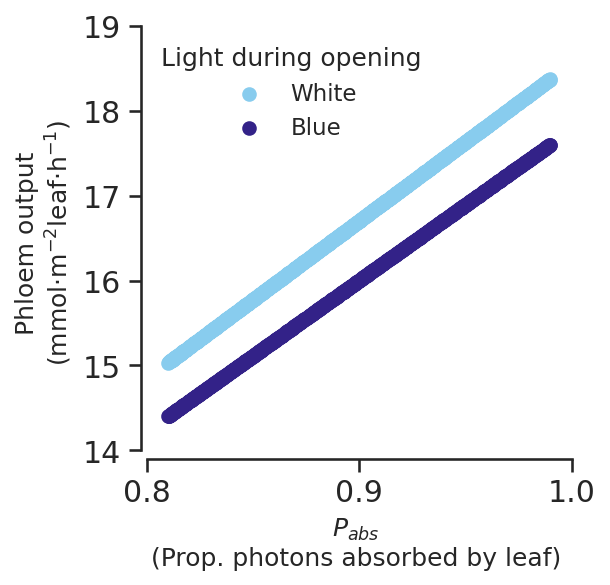

In [21]:
def phloemoutput_subfig(ax):
    for light, colour in zip(
        ["white", "blue"], [sns.color_palette()[1], sns.color_palette()[0]]
    ):
        constraints_light_df = scan_constraints[scan_constraints.light == light]
        results_light_df = scan_results[scan_constraints.light == light]

        ax.scatter(
            constraints_light_df.P_abs,
            results_light_df.Phloem_tx_overall,
            label=light.capitalize(),
            color=colour,
        )

    ax.legend(title="Light during opening")
    ax.set_xlabel("$P_{abs}$\n(Prop. photons absorbed by leaf)", size="medium")
    ax.set_ylabel(
        "Phloem output\n(mmol$\cdot$m$^{-2}$leaf$\cdot$h$^{-1}$)", size="medium"
    )

    ax.set_ylim(13.9, 19)
    ax.set_xlim(0.797, 1)
    ax.spines["left"].set_bounds(14, 19)
    ax.spines["bottom"].set_bounds(0.8, 1)
    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    # ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    # ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax.set_aspect(abs(1 - 0.8) / abs(19 - 14))

    return ax


fig, ax = plt.subplots()
phloemoutput_subfig(ax)

## 7b - What affects hexose export from the guard cell?

### Generate hexose export df

In [22]:
four_stage_GC_model = cobra.io.sbml.read_sbml_model(
    "../models/4_stage_GC.xml"
)  # read model

# get total flux across all phases
net_carbon_dict = {}
for metabolite in ["GLC", "FRU", "SUCROSE"]:
    net_metabolite = 0
    for i, phase_length in enumerate(get_phase_lengths(four_stage_GC_model)):
        phase_number = i + 1
        net_metabolite = (
            net_metabolite
            + scan_results.loc[:, f"{metabolite}_ae_gc_{phase_number}"] * phase_length
        )
    net_carbon_dict[metabolite] = net_metabolite
net_carbon_df = pd.DataFrame.from_dict(net_carbon_dict)

# correct for fact that sucrose is two hexoses
net_carbon = (
    net_carbon_df.GLC + net_carbon_df.FRU + net_carbon_df.SUCROSE * 2
) * -1  # mmol.m2-1
net_carbon = net_carbon * 10**-3  # moles.m2-1
carbon_per_gc = net_carbon / scan_constraints.N_gcs  # moles.gc-1
carbon_per_gc = carbon_per_gc * 10**15  # fmol.gc-1

No objective coefficients in model. Unclear what should be optimized


### Fit model to hexose export

In [23]:
response = carbon_per_gc
for features in [full_features, gc_features]:
    lm_1 = LinearRegression()
    lm_1.fit(features, response)
    pred = lm_1.predict(features)
    print("Mean squared error, MSE = %.2f" % mean_squared_error(response, pred))
    print("Coefficient of determination, r2 = %.2f" % r2_score(response, pred))

Mean squared error, MSE = 9919.47
Coefficient of determination, r2 = 0.41
Mean squared error, MSE = 3274.79
Coefficient of determination, r2 = 0.80


So hexose export can be better predicted using the gc features compared to all the features. Is this because it's hexose per gc?

In [24]:
response = net_carbon
for features in [full_features, gc_features]:
    lm_1 = LinearRegression()
    lm_1.fit(features, response)
    pred = lm_1.predict(features)
    print("Mean squared error, MSE = %.2f" % mean_squared_error(response, pred))
    print("Coefficient of determination, r2 = %.2f" % r2_score(response, pred))

Mean squared error, MSE = 0.00
Coefficient of determination, r2 = 0.51
Mean squared error, MSE = 0.00
Coefficient of determination, r2 = 1.00


Seems so, as we're confusing things by introducing the N_gcs division into the response

In [25]:
response = net_carbon
lm_1 = LinearRegression()
lm_1.fit(gc_features, response)
pred = lm_1.predict(gc_features)
lm_coefs = pd.DataFrame(lm_1.coef_, index=gc_features.columns).sort_values(by=0)
lm_coefs[abs(lm_coefs.loc[:, 0]) > 0.00001]

,0
V_closed,-0.009206
Os_dif,-0.000030
Os_closed,0.000025
ATPase,0.000059
Photons,0.000233
V_open,0.003493


Mainly different light colours as well as osmolarity. What if we correct for light colour?

### Create a reponse for total photons into the GC, irrespective of blue or white light

In [26]:
photon_influx = scan_results.loc[:, "Photon_tx_gc_3"]
photon_hours = scan_constraints.loc[:, "light"].apply(
    lambda x: 12 if x == "white" else 11.5
)
total_photons_per_day = photon_influx * photon_hours

In [27]:
response = net_carbon
features = np.array([total_photons_per_day]).T
lm_1 = LinearRegression()
lm_1.fit(features, response)
pred = lm_1.predict(features)
print("Mean squared error, MSE = %.6f" % mean_squared_error(response, pred))
print("Coefficient of determination, r2 = %.6f" % r2_score(response, pred))
pd.DataFrame(lm_1.coef_, index=["Photons per day"]).sort_values(by=0)

Mean squared error, MSE = 0.000000
Coefficient of determination, r2 = 0.999035


,0
Photons per day,0.00002


In [28]:
response = net_carbon
features = np.array([total_photons_per_day, gc_features.Os_dif]).T
lm_1 = LinearRegression()
lm_1.fit(features, response)
pred = lm_1.predict(features)
print("Mean squared error, MSE = %.6f" % mean_squared_error(response, pred))
print("Coefficient of determination, r2 = %.6f" % r2_score(response, pred))
pd.DataFrame(lm_1.coef_, index=["Photons per day", "Os dif"]).sort_values(by=0)

Mean squared error, MSE = 0.000000
Coefficient of determination, r2 = 0.999911


,0
Os dif,-0.00003
Photons per day,0.00002


Pretty good R2

In [29]:
response = net_carbon
features = np.array(gc_features.ATPase).reshape(-1, 1)
lm_1 = LinearRegression()
lm_1.fit(features, response)
pred = lm_1.predict(features)
print("Mean squared error, MSE = %.6f" % mean_squared_error(response, pred))
print("Coefficient of determination, r2 = %.6f" % r2_score(response, pred))
pd.DataFrame(lm_1.coef_, index=["ATPase"]).sort_values(by=0)

Mean squared error, MSE = 0.000000
Coefficient of determination, r2 = 0.075506


,0
ATPase,0.00689


ATPase can't really predict hexose export, at least not by itself

<Axes: xlabel='Photons per day into GC\n(mmol$\\cdot$m$^{-2}\\cdot$d$^{-1}$)', ylabel='Net hexose export flux from GC\n(mmol$\\cdot$m$^{-2}\\cdot$h$^{-1}$)'>

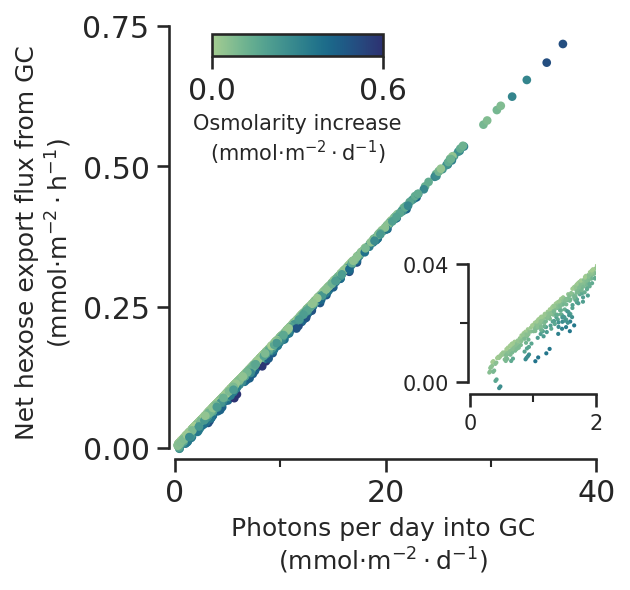

In [30]:
def photons_vs_carbon_export_subfig(ax):
    max_os_dif = scan_gc_constraints.Os_dif.max().round(1)
    norm = Normalize(vmin=0, vmax=max_os_dif)
    mappable = ScalarMappable(norm=norm, cmap=sns.color_palette("crest", as_cmap=True))

    net_carbon_mmol = net_carbon * 10**3

    ax.scatter(
        total_photons_per_day,
        net_carbon_mmol,
        c=scan_gc_constraints.Os_dif,
        norm=norm,
        s=10,
        cmap=sns.color_palette("crest", as_cmap=True),
    )

    cbaxes = ax.inset_axes([0.1, 0.93, 0.40, 0.05])
    cbar = plt.colorbar(
        mappable, cax=cbaxes, ticks=[0, max_os_dif], orientation="horizontal"
    )
    cbar.set_label("Osmolarity increase\n(mmol$\cdot$m$^{-2}\cdot$d$^{-1}$)", size=10)

    inset_ax = ax.inset_axes([0.7, 0.15, 0.3, 0.3])
    inset_ax.scatter(
        total_photons_per_day,
        net_carbon_mmol,
        c=scan_gc_constraints.Os_dif,
        s=1,
        cmap=sns.color_palette("crest", as_cmap=True),
    )
    inset_ax.set_xlim([-0.3 / 10, 2])
    inset_ax.set_ylim([-0.02 / 5, 0.04])
    inset_ax.tick_params(labelsize=10)
    inset_ax.spines["left"].set_bounds(0, 0.04)
    inset_ax.spines["bottom"].set_bounds(0, 2)
    inset_ax.yaxis.set_major_locator(MultipleLocator(0.04))
    inset_ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    inset_ax.xaxis.set_major_locator(MultipleLocator(2))
    inset_ax.xaxis.set_minor_locator(AutoMinorLocator(2))

    ax.set_xlim([-0.5, 40])
    ax.set_ylim([-0.02, 0.75])
    ax.spines["left"].set_bounds(0, 0.75)
    ax.spines["bottom"].set_bounds(0, 40)
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.set_aspect(abs(40 - 0) / abs(0.75 - 0))

    ax.set_xlabel(
        "Photons per day into GC\n" + r"(mmol$\cdot$m$^{-2}\cdot$d$^{-1}$)",
        size="medium",
    )
    ax.set_ylabel(
        "Net hexose export flux from GC\n" + r"(mmol$\cdot$m$^{-2}\cdot$h$^{-1}$)",
        size="medium",
    )

    return ax


fig, ax = plt.subplots()
photons_vs_carbon_export_subfig(ax)

### Are there any solutions that are below 0?

In [31]:
(net_carbon < 0).sum()

2

What's interesting about them?

In [32]:
scan_constraints.loc[net_carbon < 0]

,P_abs,T_l,A_l,V_gc_ind,FqFm,R_ch,L_air,L_epidermis,Vac_frac,T,...,N_gcs,n,m,r,s,C_apo,A_closed,A_open,ATPase,light
180,0.905621,0.000238,1.0,5.504346e-13,0.851331,0.042463,0.229569,0.166053,0.804005,297.456238,...,6.273035e+08,1.96254,0.80448,6.905245e-14,1.886476e-13,0.028729,1.953838,11.38203,8.971524,white
1152,0.905621,0.000238,1.0,5.504346e-13,0.851331,0.042463,0.229569,0.166053,0.804005,297.456238,...,6.273035e+08,1.96254,0.80448,6.905245e-14,1.886476e-13,0.028729,1.953838,11.38203,8.971524,blue


In [33]:
scan_gc_constraints.loc[net_carbon < 0]

,V_closed,V_open,Os_closed,Os_open,Photons,ATPase,Os_dif
180,0.000203,0.000611,0.035224,0.296097,0.039867,0.005628,0.260872
1152,0.000203,0.000611,0.035224,0.296097,0.039867,0.005628,0.260872


Ok they are the same just with different light colours. Is it the photon/od_dif ratio?

In [34]:
scan_gc_constraints.loc[180, "Photons"] / scan_gc_constraints.loc[180, "Os_dif"]

0.15282224853377138

In [35]:
(scan_gc_constraints.loc[:, "Photons"] / scan_gc_constraints.loc[:, "Os_dif"]).min()

0.15282224853377138

Yes, it has the lowest photon:od_diff ratio of any combination

## At our predicted level of osmolarity and other guard cell parameters, what would FqFm.R_ch need to be for guard cell to act as a sink?

$e = FqFm \cdot R_{ch}$ <- We want to know e, that is the capacity of guard cell vs mesophyll. Function of efficiency and number of chloroplasts

$P_{gc} = e \cdot v\_prop_{gc} \cdot P$

$e = \frac{P_{gc}}{v\_prop_{gc} \cdot P}$

In [36]:
P = 150 * paper_constraints.P_abs
P = P * 10**-3 * 60 * 60  # umolessec-1 -> mmolhr-1

In [37]:
V_l = (
    paper_constraints.T_l * paper_constraints.A_l
)  # volume of leaf is area x thickness
V_l = V_l * 10**3  # (Total leaf volume) m3 -> dm3 = 10**3

V_gc = (
    paper_constraints.V_gc_ind * paper_constraints.N_gcs
)  # total volume of gc in leaf

# volume of meosphyll is leaf that isn't epidermis or air
V_me = V_l * (1 - paper_constraints.L_epidermis) * (1 - paper_constraints.L_air)

v_prop_gc = V_gc / V_me  # volume of gc is negligable

In [38]:
response = net_carbon
features = np.array([total_photons_per_day, gc_features.Os_dif]).T
lm_1 = LinearRegression()
lm_1.fit(features, response)
pred = lm_1.predict(features)
print("Mean squared error, MSE = %.6f" % mean_squared_error(response, pred))
print("Coefficient of determination, r2 = %.6f" % r2_score(response, pred))
print(f"Intercept: {lm_1.intercept_}")
pd.DataFrame(lm_1.coef_, index=["Photons per day", "Os dif"]).sort_values(by=0)

Mean squared error, MSE = 0.000000
Coefficient of determination, r2 = 0.999911
Intercept: -6.796678100605175e-08


,0
Os dif,-0.00003
Photons per day,0.00002


$ C_{net} = -3\cdot10^{-5}\cdot Os_{dif} + 2\cdot10^{-5}\cdot P_{day} - 6.80 \cdot10^{-8}$

$ 0 = -3\cdot10^{-5}\cdot 0.016 + 2\cdot10^{-5}\cdot P_{day} - 6.80 \cdot10^{-8}$

$ \frac{6.80 \cdot10^{-8}  + -3\cdot10^{-5}\cdot 0.016}{2\cdot10^{-5}} = P_{day}$

In [39]:
os_dif_coef = lm_1.coef_[1]
photons_per_day_coef = lm_1.coef_[0]
os_in_selected_scenarios = paper_gc_constraints.Os_dif
intercept = lm_1.intercept_

In [40]:
photons_needed = (
    intercept - os_dif_coef * os_in_selected_scenarios
) / photons_per_day_coef
photons_needed

0.020217982715252002

In [41]:
total_photons_per_day.min() / photons_needed

14.958732838471718

So at that osmolarity for the guard cell to act as sink tissue the total level of photons coming in would have to be 15x lower than we see in any of our scenarios, which will be for blue light

In [42]:
photon_influx = photons_needed / 11.5

$e = \frac{P_{gc}}{v\_prop_{gc} \cdot P}$

In [43]:
e = photon_influx / (v_prop_gc * P)
e * 100

0.1195337390747749

So the capacity for photosynthesis in the guard cell only needs to be 0.1% of that of the mesophyll to act as a source tissue

### What is the range of photosynthetic capacities that we use?

In [44]:
capacity_percentages = (scan_constraints.FqFm * scan_constraints.R_ch) * 100
print(f"High: {capacity_percentages.max()}")
print(f"Low: {capacity_percentages.min()}")

High: 16.398489377751467
Low: 2.8086635016180743


## 7c - So does the ATPase have an effect on starch if not on hexose export very much?

### How many solutions utilise starch?

In [45]:
starch = scan_results.STARCH_p_gc_Linker_1 - scan_results.STARCH_p_gc_Linker_2
print(f"{(starch > 0).sum()} or {(starch > 0).sum()/len(starch) * 100:.0f}%")

1891 or 97%


## In how many of those solutions is the ATPase constrained?

In [46]:
atpase_constrained = (
    abs(scan_gc_constraints.ATPase - scan_results.PROTON_ATPase_c_gc_2) < 0.000001
)
(atpase_constrained & starch > 0).sum()

1890

So there is one solution which doesn't

In [47]:
scan_gc_constraints[(~atpase_constrained & starch > 0)]

,V_closed,V_open,Os_closed,Os_open,Photons,ATPase,Os_dif
1685,0.000254,0.000316,0.050405,0.075048,1.393555,0.01318,0.024642


In [48]:
(scan_gc_constraints.loc[1685] - scan_gc_constraints.mean()) / scan_gc_constraints.std()

V_closed     0.111731
V_open      -0.602100
Os_closed   -0.024406
Os_open     -0.918384
Photons      1.760322
ATPase       1.728109
Os_dif      -1.023596
dtype: float64

High photons, high ATPase, low osmolarity dif

## How many constrained solutions don't use starch?

In [49]:
(atpase_constrained & (starch == 0)).sum()

1

In [50]:
scan_gc_constraints[(atpase_constrained & (starch == 0))]

,V_closed,V_open,Os_closed,Os_open,Photons,ATPase,Os_dif
1315,0.000356,0.000376,0.073848,0.082492,0.806864,0.004604,0.008644


In [51]:
(scan_gc_constraints.loc[1315] - scan_gc_constraints.mean()) / scan_gc_constraints.std()

V_closed     0.970232
V_open      -0.337247
Os_closed    0.787662
Os_open     -0.858245
Photons      0.509296
ATPase      -0.255409
Os_dif      -1.168544
dtype: float64

Osmolarity difference is low, photons are high, atpase is low. Closed osmolarity is high, forcing the use of something else?

Increase per GC allows comparison with literature values

In [52]:
starch_per_gc = starch * 10**-3 / scan_constraints.N_gcs * 10**15  # fmol.gc-1

In [53]:
horrer_starch_level = 184

In [54]:
os_increase_per_gc = (
    scan_gc_constraints.Os_dif * 10**-3 / scan_constraints.N_gcs * 10**15
)
protons_moved_per_gc = (
    scan_results.PROTON_ATPase_c_gc_2 * 10**-3 / scan_constraints.N_gcs * 10**15
)

In [55]:
protons_moved_per_gc.max()

16.995468262384303

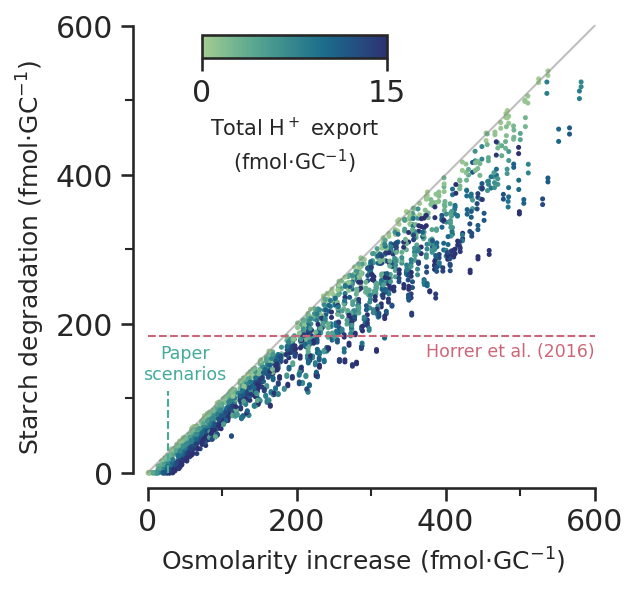

In [56]:
def starch_vs_os_subfig(ax):
    dot_size = 2

    norm = Normalize(vmin=0, vmax=15)
    mappable = ScalarMappable(norm=norm, cmap=sns.color_palette("crest", as_cmap=True))

    ax.plot([0, 600], [0, 600], c="grey", alpha=0.5, clip_on=False, linewidth=1)

    sc = ax.scatter(
        os_increase_per_gc,
        starch_per_gc,
        s=dot_size,
        c=protons_moved_per_gc,
        norm=norm,
        cmap=sns.color_palette("crest", as_cmap=True),
    )

    cbaxes = ax.inset_axes([0.15, 0.93, 0.40, 0.05])
    cbar = plt.colorbar(mappable, cax=cbaxes, ticks=[0, 15], orientation="horizontal")
    cbar.set_label("Total H$^+$ export\n(fmol$\cdot$GC$^{-1}$)", size=10)

    y_max = 600
    y_min = -20
    x_max = 600
    x_min = -20
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x_min, x_max)
    ax.spines["left"].set_bounds(0, y_max)
    ax.spines["bottom"].set_bounds(0, x_max)
    ax.xaxis.set_major_locator(MultipleLocator(200))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(200))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_aspect(1)

    ax.set_xlabel("Osmolarity increase (fmol$\cdot$GC$^{-1}$)", size="medium")
    ax.set_ylabel(r"Starch degradation (fmol$\cdot$GC$^{-1}$)", size="medium")
    # ax.hlines(-155, xmin=0.15, xmax=0.99, clip_on=False, linewidth=1, color='.15')

    ax.hlines(
        184,
        xmin=0,
        xmax=x_max,
        linewidth=1,
        linestyle="--",
        color=sns.color_palette()[6],
    )
    ax.text(
        x_max,
        175,
        "Horrer et al. (2016)",
        ha="right",
        va="top",
        size="x-small",
        color=sns.color_palette()[6],
    )

    paper_scenarios_colour = sns.color_palette()[2]
    ax.vlines(
        26.83,
        ymin=0,
        ymax=110,
        linewidth=1,
        linestyle="--",
        color=paper_scenarios_colour,
    )
    ax.text(
        50,
        120,
        "Paper\nscenarios",
        ha="center",
        va="bottom",
        size="x-small",
        color=paper_scenarios_colour,
    )

    return ax


fig, ax = plt.subplots(figsize=(6, 4))

starch_vs_os_subfig(ax)

fig.savefig("../outputs/constraint_scan/atpase_vs_starch.svg")
fig.savefig("../outputs/constraint_scan/atpase_vs_starch.png")

### How do starch levels vary with white/blue light?

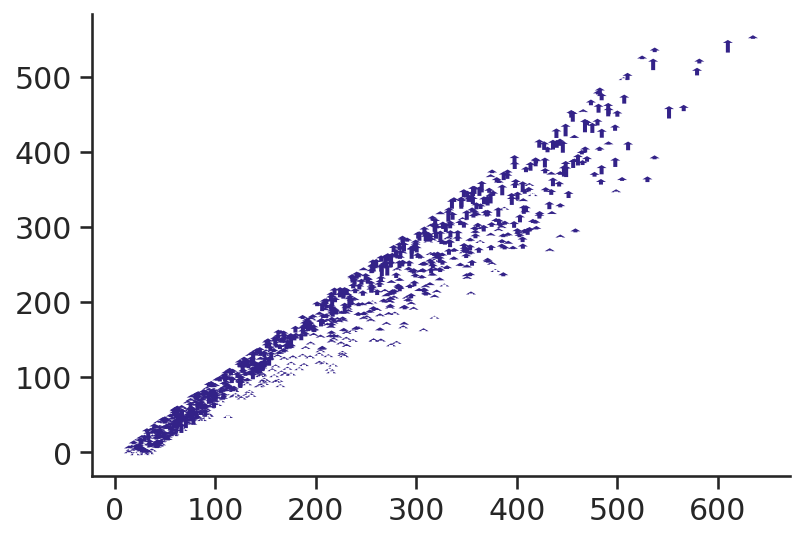

In [57]:
fig, ax = plt.subplots(figsize=(6, 4))

blue_higher = 0
white_higher = 0
same_starch = 0

len_light = int(len(scan_constraints) / 2)

for i in range(len_light):
    x = os_increase_per_gc[i]

    y_white = starch_per_gc[i]
    y_blue = starch_per_gc[i + len_light]

    if y_blue > y_white:  # blue higher
        colour = colours[0]
        blue_higher += 1
    elif y_blue < y_white:
        colour = colours[1]
        white_higher += 1
    else:
        same_starch += 1
        colour = "black"

    ax.arrow(
        x,
        y_white,
        0,
        y_blue - y_white,
        color=colour,
        length_includes_head=True,
        width=4,
        head_width=10,
        head_length=4,
        linewidth=0,
    )

In [58]:
print(f"Blue higher: {blue_higher}")
print(f"White higher: {white_higher}")
print(f"Same starch: {same_starch}")

Blue higher: 949
White higher: 0
Same starch: 23


In [59]:
starch_differences = (
    (scan_results[scan_constraints.light == "blue"].reset_index())
    - (scan_results[scan_constraints.light == "white"].reset_index())
).STARCH_p_gc_Linker_1

In [60]:
(starch_differences > 0).sum()

949

In [61]:
scan_results[scan_constraints.light == "blue"].reset_index()[
    (starch_differences == 0)
].STARCH_p_gc_Linker_1

10     0.0
38     0.0
80     0.0
104    0.0
126    0.0
128    0.0
150    0.0
231    0.0
239    0.0
280    0.0
292    0.0
313    0.0
343    0.0
374    0.0
438    0.0
453    0.0
531    0.0
612    0.0
674    0.0
853    0.0
876    0.0
905    0.0
922    0.0
Name: STARCH_p_gc_Linker_1, dtype: float64

Starch is only equal when it's 0

In [62]:
high_starch = scan_results[starch_per_gc > horrer_starch_level]
print(len(high_starch))
print(
    (
        (scan_constraints.loc[high_starch.index, "light"] == "white").sum()
        / (len(scan_results) / 2)
        * 100
    ).round(0)
)
print(
    (
        (scan_constraints.loc[high_starch.index, "light"] == "blue").sum()
        / (len(scan_results) / 2)
        * 100
    ).round(0)
)

840
43.0
44.0


In [63]:
selected_scenarios_max_starch = (
    paper_results.loc[:, "STARCH_p_gc_Linker_1"]
    - paper_results.loc[:, "STARCH_p_gc_Linker_2"]
).max()
selected_scenarios_max_starch = (
    selected_scenarios_max_starch * 10**-3 / paper_constraints.N_gcs * 10**15
)

In [64]:
higher_than_scenarios_starch = scan_results[
    starch_per_gc > selected_scenarios_max_starch
]
print(len(higher_than_scenarios_starch))
print(
    (
        (
            scan_constraints.loc[higher_than_scenarios_starch.index, "light"] == "white"
        ).sum()
        / (len(scan_results) / 2)
        * 100
    ).round(0)
)
print(
    (
        (
            scan_constraints.loc[higher_than_scenarios_starch.index, "light"] == "blue"
        ).sum()
        / (len(scan_results) / 2)
        * 100
    ).round(0)
)

1824
93.0
95.0


## How is starch used?

What proportion of white light solutions that degrade starch use it for osmoticum?

In [65]:
(
    (
        (scan_constraints["light"] == "white")
        & (starch > 0)
        & (scan_results.RXN_2141_p_gc_2 > 0)
    ).sum()
) / ((scan_constraints["light"] == "white") & (starch > 0)).sum() * 100

100.0

What proportion of white light solutions that degrade starch use it for energy?

In [66]:
(
    (
        (scan_constraints["light"] == "white")
        & (starch > 0)
        & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
    ).sum()
) / ((scan_constraints["light"] == "white") & (starch > 0)).sum() * 100

2.8662420382165608

In the solutions that use it for energy, what is the average % used for energy?

In [67]:
(
    (
        (
            scan_results[
                (
                    (
                        (scan_constraints["light"] == "white")
                        & (starch > 0)
                        & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
                    )
                )
            ].MALTODEG_RXN_c_gc_2
        )
        / starch[
            (
                (scan_constraints["light"] == "white")
                & (starch > 0)
                & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
            )
        ]
    )
    * 100
).mean()

2.0182863988549395

What proportion of blue light solutions that degrade starch use it for osmoticum?

In [68]:
(
    (
        (scan_constraints["light"] == "blue")
        & (starch > 0)
        & (scan_results.RXN_2141_p_gc_2 > 0)
    ).sum()
) / ((scan_constraints["light"] == "blue") & (starch > 0)).sum() * 100

99.89462592202318

In [69]:
((scan_constraints["light"] == "blue") & (starch > 0)).sum() - (
    (
        (scan_constraints["light"] == "blue")
        & (starch > 0)
        & (scan_results.RXN_2141_p_gc_2 > 0)
    ).sum()
)

1

Only one solution doesn't

In [70]:
scan_constraints[
    (
        (scan_constraints["light"] == "blue")
        & (starch > 0)
        & ~(scan_results.RXN_2141_p_gc_2 > 0)
    )
]

,P_abs,T_l,A_l,V_gc_ind,FqFm,R_ch,L_air,L_epidermis,Vac_frac,T,...,N_gcs,n,m,r,s,C_apo,A_closed,A_open,ATPase,light
1685,0.821423,0.000237,1.0,3.854387e-12,0.790419,0.17526,0.229149,0.2216,0.899394,283.991986,...,8.359438e+08,1.749547,0.84542,6.715197e-14,1.344834e-13,0.031261,2.529549,3.62111,15.767152,blue


1685 is solution without constrained ATPase

What proportion of blue light solutions that degrade starch use it for energy?

In [71]:
(
    (
        (scan_constraints["light"] == "blue")
        & (starch > 0)
        & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
    ).sum()
) / ((scan_constraints["light"] == "blue") & (starch > 0)).sum() * 100

97.36564805057955

In [72]:
(
    (scan_constraints["light"] == "blue")
    & (starch > 0)
    & ~(scan_results.MALTODEG_RXN_c_gc_2 > 0)
).sum()

25

25 solutions that use starch in blue light don't use the energy pathway

In [73]:
(
    (
        (
            scan_results[
                (
                    (scan_constraints["light"] == "blue")
                    & (starch > 0)
                    & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
                )
            ].MALTODEG_RXN_c_gc_2
        )
        / starch[
            (
                (scan_constraints["light"] == "blue")
                & (starch > 0)
                & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
            )
        ]
    )
    * 100
).mean()

4.619193741648066

Average of 5% of starch degraded was used for energy

## 7d - How does glucose increase during opening vary with starch, and why isn't it totally linear?

Is sucrose degaded in the cytoplasm in any solutions?

In [74]:
(scan_results[starch > 0]["RXN_1461_c_gc_2"] > 0).sum()

0

No

In [75]:
sucrose_degraded_v = scan_results[starch > 0]["RXN_1461_v_gc_2"] > 0.000001
no_sucrose_degraded_v = scan_results[starch > 0]["RXN_1461_v_gc_2"] < 0.000001
glucose_import_into_vacuole = (
    scan_results[starch > 0]["GLC_PROTON_rev_cv_gc_2"] > 0.000001
)
no_glucose_import_into_vacuole = (
    scan_results[starch > 0]["GLC_PROTON_rev_cv_gc_2"] < 0.000001
)

In [76]:
sucrose_deg_and_glc_import = sucrose_degraded_v & glucose_import_into_vacuole
sucrose_deg_no_glc_import = sucrose_degraded_v & no_glucose_import_into_vacuole
no_sucrose_deg_glc_import = no_sucrose_degraded_v & glucose_import_into_vacuole
no_sucrose_deg_no_glc_import = no_sucrose_degraded_v & no_glucose_import_into_vacuole

In [77]:
conditions = [
    sucrose_deg_and_glc_import,
    sucrose_deg_no_glc_import,
    no_sucrose_deg_glc_import,
    no_sucrose_deg_no_glc_import,
]
labels = ["+ S.d. + G.i.", "+ S.d - G.i.", "- S.d + G.i.", "- S.d - G.i."]

In [78]:
for condition, label in zip(conditions, labels):
    print(f"{label}:")
    print(
        f"Length: {(condition).sum()} ({((condition).sum()/len(scan_constraints[starch > 0]) * 100).round(1)}%)"
    )
    starch_proportion = (
        (
            scan_results[starch > 0][condition].STARCH_p_gc_Linker_1
            / scan_gc_constraints.loc[starch > 0][condition].Os_dif
        )
        * 100
    ).median()
    print(f"Starch median % of osmolarity: {starch_proportion}")
    starch_proportion = (
        (
            scan_results[starch > 0][condition].STARCH_p_gc_Linker_1
            / scan_gc_constraints.loc[starch > 0][condition].Os_dif
        )
        * 100
    ).mean()
    print(f"Starch mean % of osmolarity: {starch_proportion}")
    starch_proportion = (
        (
            scan_results[starch > 0][condition].STARCH_p_gc_Linker_1
            / scan_gc_constraints.loc[starch > 0][condition].Os_dif
        )
        * 100
    ).max()
    print(f"Starch max % of osmolarity: {starch_proportion}")
    starch_proportion = (
        (
            scan_results[starch > 0][condition].STARCH_p_gc_Linker_1
            / scan_gc_constraints.loc[starch > 0][condition].Os_dif
        )
        * 100
    ).min()
    print(f"Starch min % of osmolarity: {starch_proportion}")

+ S.d. + G.i.:
Length: 962 (50.9%)
Starch median % of osmolarity: 79.21003879110927
Starch mean % of osmolarity: 78.82409293570552
Starch max % of osmolarity: 100.92739328083624
Starch min % of osmolarity: 43.44248513983036
+ S.d - G.i.:
Length: 3 (0.2%)
Starch median % of osmolarity: 48.051054413586435
Starch mean % of osmolarity: 49.40105376723963
Starch max % of osmolarity: 52.313844398794004
Starch min % of osmolarity: 47.83826248933846
- S.d + G.i.:
Length: 822 (43.5%)
Starch median % of osmolarity: 85.04872218181076
Starch mean % of osmolarity: 81.84066697246345
Starch max % of osmolarity: 100.86764024046666
Starch min % of osmolarity: 22.244386800270526
- S.d - G.i.:
Length: 104 (5.5%)
Starch median % of osmolarity: 31.46259872630749
Starch mean % of osmolarity: 32.09721877147245
Starch max % of osmolarity: 84.97623832194996
Starch min % of osmolarity: 0.3001448817724928


In [79]:
glc_increase = (
    scan_results[starch > 0].GLC_total_pseudolinker_2
    - scan_results[starch > 0].GLC_total_pseudolinker_1
)
glc_increase_per_gc = glc_increase * 10**-3 / scan_constraints.N_gcs * 10**15

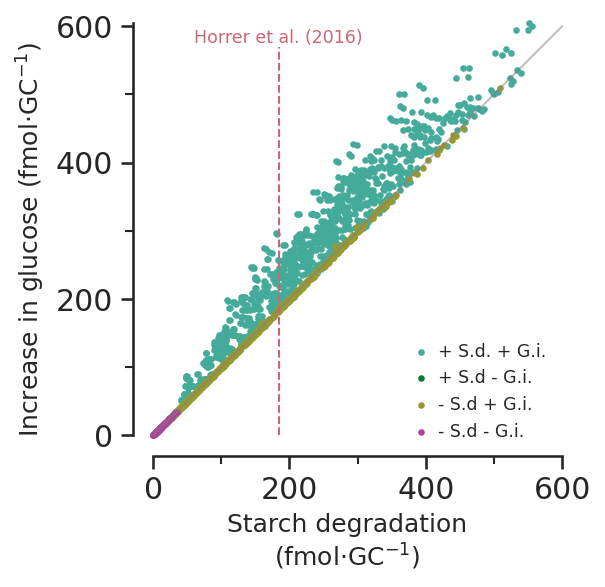

In [80]:
def glucose_vs_starch_subfig(ax):
    x = [0, 600]
    y = [0, 600]

    size = 10

    ax.plot(x, y, c="grey", alpha=0.5, clip_on=False, linewidth=1)

    conditions = [
        sucrose_deg_and_glc_import,
        sucrose_deg_no_glc_import,
        no_sucrose_deg_glc_import,
        no_sucrose_deg_no_glc_import,
    ]
    colours = [
        sns.color_palette()[2],
        sns.color_palette()[3],
        sns.color_palette()[4],
        sns.color_palette()[8],
    ]
    labels = ["+ S.d. + G.i.", "+ S.d - G.i.", "- S.d + G.i.", "- S.d - G.i."]

    glucose_increase_max = glc_increase_per_gc.max()

    for condition, colour, label in zip(conditions, colours, labels):
        ax.scatter(
            starch_per_gc[starch > 0][condition],
            glc_increase_per_gc[starch > 0][condition],
            color=colour,
            s=size,
            label=label,
            linewidths=0,
            clip_on=False,
        )

    ax.set_xlabel("Starch degradation\n" r"(fmol$\cdot$GC$^{-1}$)", size="medium")
    ax.set_ylabel("Increase in glucose (fmol$\cdot$GC$^{-1}$)", size="medium")

    y_max = glucose_increase_max
    x_max = 600
    major_increment = 200
    ax.set_ylim(None, y_max)
    ax.set_xlim(None, x_max)
    ax.spines["left"].set_bounds(0, y_max)
    ax.spines["bottom"].set_bounds(0, x_max)
    ax.xaxis.set_major_locator(MultipleLocator(major_increment))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(major_increment))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_aspect("equal")

    ax.vlines(
        184, ymin=0, ymax=570, linewidth=1, linestyle="--", color=sns.color_palette()[6]
    )
    ax.text(
        184,
        570,
        "Horrer et al. (2016)",
        ha="center",
        va="bottom",
        size="x-small",
        color=sns.color_palette()[6],
    )

    ax.legend(
        loc="lower right", bbox_to_anchor=(1, 0), handletextpad=0, fontsize="x-small"
    )

    return ax


fig, ax = plt.subplots()

glucose_vs_starch_subfig(ax)

fig.savefig("../outputs/constraint_scan/starch_vs_glucose.svg")
fig.savefig("../outputs/constraint_scan/starch_vs_glucose.png", dpi=300)

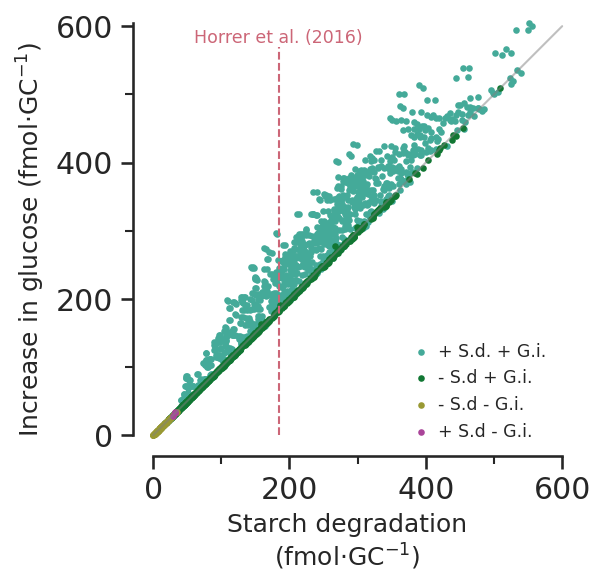

In [81]:
def glucose_vs_starch_subfig(ax):
    x = [0, 600]
    y = [0, 600]

    size = 10

    ax.plot(x, y, c="grey", alpha=0.5, clip_on=False, linewidth=1)

    conditions = [
        sucrose_deg_and_glc_import,
        no_sucrose_deg_glc_import,
        no_sucrose_deg_no_glc_import,
        sucrose_deg_no_glc_import,
    ]
    colours = [
        sns.color_palette()[2],
        sns.color_palette()[3],
        sns.color_palette()[4],
        sns.color_palette()[8],
    ]
    labels = ["+ S.d. + G.i.", "- S.d + G.i.", "- S.d - G.i.", "+ S.d - G.i."]

    glucose_increase_max = glc_increase_per_gc.max()

    for condition, colour, label in zip(conditions, colours, labels):
        ax.scatter(
            starch_per_gc[starch > 0][condition],
            glc_increase_per_gc[starch > 0][condition],
            color=colour,
            s=size,
            label=label,
            linewidths=0,
            clip_on=False,
        )

    ax.set_xlabel("Starch degradation\n" r"(fmol$\cdot$GC$^{-1}$)", size="medium")
    ax.set_ylabel("Increase in glucose (fmol$\cdot$GC$^{-1}$)", size="medium")

    y_max = glucose_increase_max
    x_max = 600
    major_increment = 200
    ax.set_ylim(None, y_max)
    ax.set_xlim(None, x_max)
    ax.spines["left"].set_bounds(0, y_max)
    ax.spines["bottom"].set_bounds(0, x_max)
    ax.xaxis.set_major_locator(MultipleLocator(major_increment))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(major_increment))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_aspect("equal")

    ax.vlines(
        184, ymin=0, ymax=570, linewidth=1, linestyle="--", color=sns.color_palette()[6]
    )
    ax.text(
        184,
        570,
        "Horrer et al. (2016)",
        ha="center",
        va="bottom",
        size="x-small",
        color=sns.color_palette()[6],
    )

    ax.legend(
        loc="lower right", bbox_to_anchor=(1, 0), handletextpad=0, fontsize="x-small"
    )

    return ax


fig, ax = plt.subplots()

glucose_vs_starch_subfig(ax)

fig.savefig("../outputs/constraint_scan/starch_vs_glucose.svg")
fig.savefig("../outputs/constraint_scan/starch_vs_glucose.png", dpi=300)

## Combine subfigures

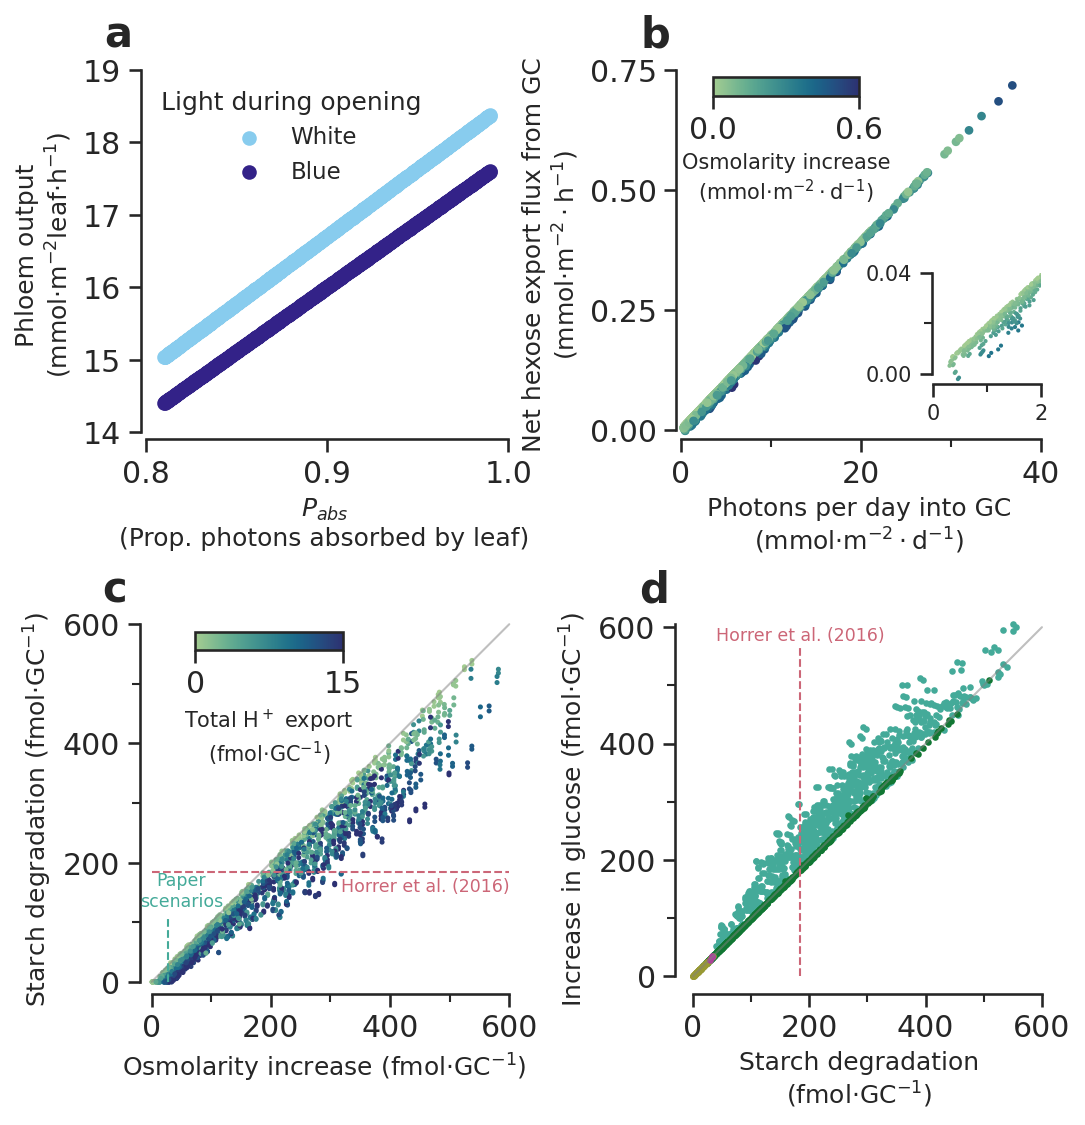

In [82]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

plt.subplots_adjust(hspace=0.5, wspace=0.35)

phloemoutput_subfig(axs[0][0])

photons_vs_carbon_export_subfig(axs[0][1])

starch_vs_os_subfig(axs[1][0])

glucose_vs_starch_subfig(axs[1][1])
axs[1][1].get_legend().remove()

for ax, letter in zip(
    [axs[0][0], axs[0][1], axs[1][0], axs[1][1]], ["a", "b", "c", "d"]
):
    ax.text(-0.1, 1.06, letter, transform=ax.transAxes, size=20, weight="bold")

fig.savefig(
    "../outputs/constraint_scan/constraint_scan_analysis_plot.svg", transparent=True
)
fig.savefig(
    "../outputs/constraint_scan/constraint_scan_analysis_plot.png", transparent=True
)

------------

## Extra analyses not included

### What is the ratio of mitochondrial to plastidic ATP synthase?

Text(0.5, 0, 'Plastidial ATP Synthase\nMitochondrial ATP Synthase')

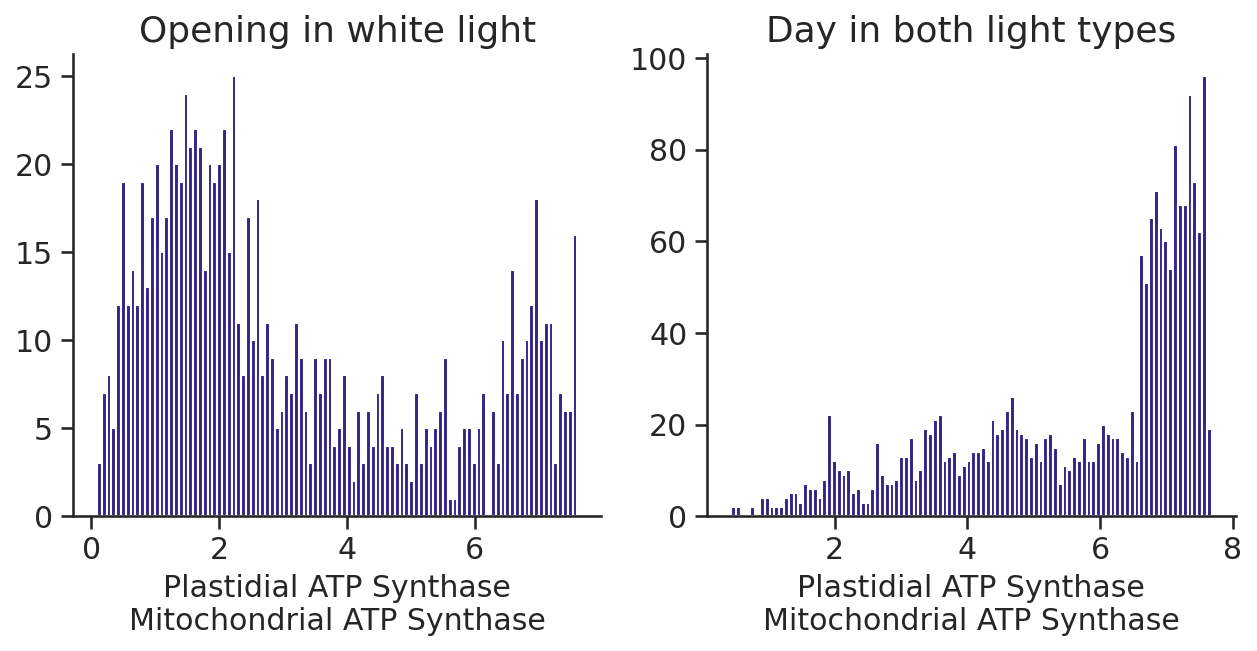

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(
    scan_results.Plastidial_ATP_Synthase_p_gc_2[scan_constraints.light == "white"]
    / scan_results.Mitochondrial_ATP_Synthase_m_gc_2[scan_constraints.light == "white"],
    bins=100,
)
axs[0].set_title("Opening in white light")
axs[0].set_xlabel("Plastidial ATP Synthase\nMitochondrial ATP Synthase")
axs[1].hist(
    scan_results.Plastidial_ATP_Synthase_p_gc_3
    / scan_results.Mitochondrial_ATP_Synthase_m_gc_3,
    bins=100,
)
axs[1].set_title("Day in both light types")
axs[1].set_xlabel("Plastidial ATP Synthase\nMitochondrial ATP Synthase")

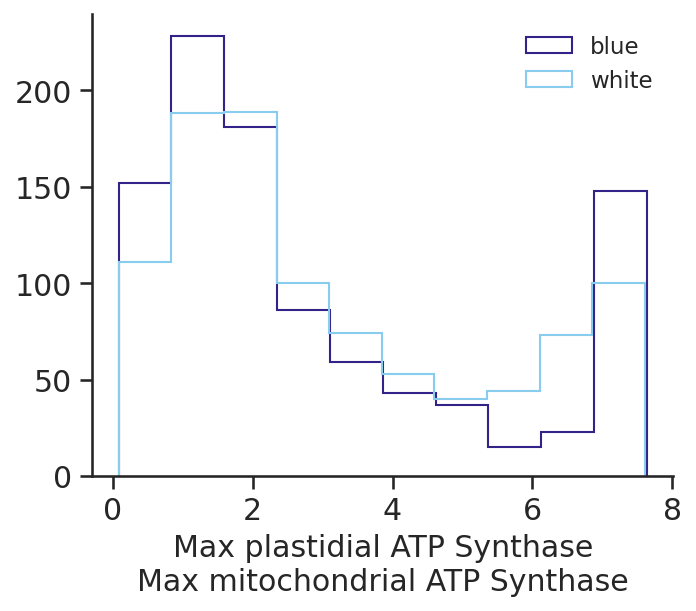

In [84]:
fig, ax = plt.subplots(1, figsize=(5, 4))

plastidial_atp_max = scan_results.loc[
    :, ["Plastidial_ATP_Synthase_p_gc_3", "Plastidial_ATP_Synthase_p_gc_2"]
].max(axis=1)
mitochondial_atp_max = scan_results.loc[
    :, ["Mitochondrial_ATP_Synthase_m_gc_3", "Mitochondrial_ATP_Synthase_m_gc_2"]
].max(axis=1)

for light in ["blue", "white"]:
    ax.hist(
        plastidial_atp_max[scan_constraints.light == light]
        / mitochondial_atp_max[scan_constraints.light == light],
        histtype="step",
        label=light,
    )

ax.set_xlabel("Max plastidial ATP Synthase\nMax mitochondrial ATP Synthase")

ax.legend()

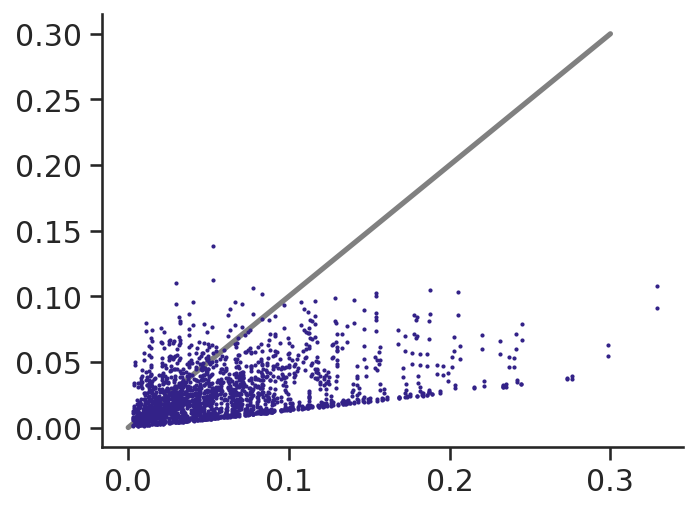

In [85]:
fig, ax = plt.subplots()

ax.plot([0, 0.3], [0, 0.3], c="grey", zorder=0)
ax.scatter(plastidial_atp_max, mitochondial_atp_max, s=1)

In [86]:
(plastidial_atp_max / mitochondial_atp_max).min()

0.08544687640486794

## Almost all starch is used for glucose, and PEP carboxykinase reaction never runs

In [87]:
(scan_results.PEPCARBOX_RXN_c_gc_2 > 0).sum()

0

In [88]:
(scan_results.PEPDEPHOS_RXN_c_gc_2 > 0).sum()

982

In [89]:
((scan_results.MALTODEG_RXN_c_gc_2 > 0) & (scan_results.PEPDEPHOS_RXN_c_gc_2 > 0)).sum()

951

In [90]:
((scan_results.MALTODEG_RXN_c_gc_2 > 0) & (scan_results.PYRUVDEH_RXN_m_gc_2 > 0)).sum()

951

In [91]:
(
    (scan_results.MALTODEG_RXN_c_gc_2 > 0)
    & (scan_results.ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc_2 > 0)
).sum()

951

<Axes: >

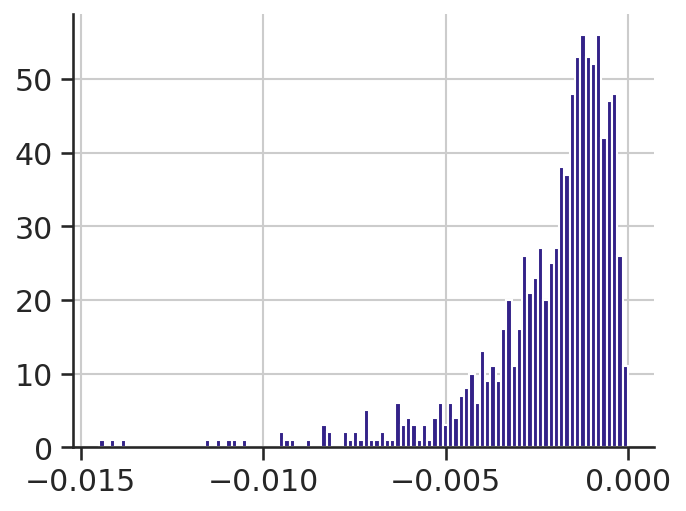

In [92]:
(
    scan_results[(scan_results.MALTODEG_RXN_c_gc_2 > 0)].MALTODEG_RXN_c_gc_2 / 2
    - scan_results[(scan_results.MALTODEG_RXN_c_gc_2 > 0)].PEPDEPHOS_RXN_c_gc_2
).hist(bins=100)

<Axes: >

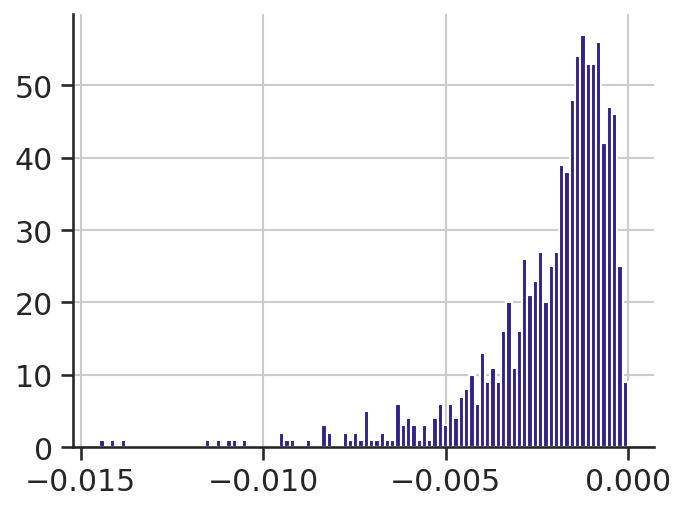

In [93]:
(
    scan_results[(scan_results.MALTODEG_RXN_c_gc_2 > 0)].MALTODEG_RXN_c_gc_2 / 2
    - scan_results[(scan_results.MALTODEG_RXN_c_gc_2 > 0)].PYRUVDEH_RXN_m_gc_2
).hist(bins=100)

In [94]:
(
    scan_results[(scan_results.MALTODEG_RXN_c_gc_2 > 0)].MALTODEG_RXN_c_gc_2
    - scan_results[
        (scan_results.MALTODEG_RXN_c_gc_2 > 0)
    ].ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc_2
)

25      0.000994
32      0.000602
58      0.000030
140     0.002853
148     0.002621
          ...   
1939   -0.003483
1940    0.003833
1941   -0.001579
1942   -0.000820
1943   -0.003544
Length: 951, dtype: float64

In [95]:
(scan_results.MAL_total_pseudolinker_2 > 0).sum()

78

In [96]:
scan_constraints[
    (
        (scan_results.MAL_total_pseudolinker_2 - scan_results.MAL_total_pseudolinker_1)
        > 0
    )
]

,P_abs,T_l,A_l,V_gc_ind,FqFm,R_ch,L_air,L_epidermis,Vac_frac,T,...,N_gcs,n,m,r,s,C_apo,A_closed,A_open,ATPase,light
1384,0.856283,0.000233,1.0,3.557774e-12,0.829166,0.09021,0.325547,0.178134,0.821274,290.830057,...,2.209913e+08,2.157369,0.845391,7.202105e-14,1.351502e-13,0.031031,3.986023,10.771568,0.018741,blue


In [97]:
starch[1384]

0.0774713614589535

In [98]:
(scan_constraints.loc[1384] - scan_constraints.mean()) / scan_constraints.std()

/tmp/ipykernel_3079511/1907229730.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  (scan_constraints.loc[1384]-scan_constraints.mean())/scan_constraints.std()
/tmp/ipykernel_3079511/1907229730.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  (scan_constraints.loc[1384]-scan_constraints.mean())/scan_constraints.std()


ATPase        -1.727007
A_closed       1.766129
A_l                 NaN
A_open         1.255356
C_apo          0.225023
FqFm          -0.498871
L_air          0.896352
L_epidermis    0.197816
N_gcs         -1.572157
P_abs         -0.835521
R              0.999743
R_ch          -0.440596
T              0.043976
T_l            1.367673
V_gc_ind       1.214546
Vac_frac      -0.104569
light               NaN
m             -0.946882
n              0.543079
r              0.814312
s             -1.123443
dtype: object

In [99]:
scan_constraints.loc[1384].ATPase

0.0187406648439282

In [100]:
scan_constraints.mean().ATPase

/tmp/ipykernel_3079511/856568451.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  scan_constraints.mean().ATPase


8.503141757759833

In [101]:
atpase_constrained[1384]

True

In [102]:
scan_results.loc[1384].MALTODEG_RXN_c_gc_2 / starch[1384] * 100

6.024443026773995

In [103]:
scan_results.loc[1384].RXN_2141_p_gc_2

0.0728041434257927

In [104]:
scan_results.loc[1384].MALATE_DEH_RXN_m_gc_2

0.0062194802213911

In [105]:
scan_results.loc[1384].ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc_2

0.0031105199642739

In [106]:
(scan_gc_constraints.loc[1384] - scan_gc_constraints.mean()) / scan_gc_constraints.std()

V_closed    -1.252034
V_open      -1.102307
Os_closed   -0.921524
Os_open     -0.706567
Photons     -0.761435
ATPase      -1.319215
Os_dif      -0.551403
dtype: float64

In [113]:
for i in [i+1 for i in range(4)]:
    reaction = f"PALMITATE_c_gc_Linker_{i}"
    print(reaction)
    print(scan_results.loc[:, reaction].sum())

PALMITATE_c_gc_Linker_1
0.0
PALMITATE_c_gc_Linker_2
0.0
PALMITATE_c_gc_Linker_3
0.0
PALMITATE_c_gc_Linker_4
0.0
